In [1]:
# !pip install HMMLearn

In [2]:
from hmmlearn.hmm import MultinomialHMM
from matplotlib import cm, pyplot as plt
import seaborn
from matplotlib.dates import YearLocator, MonthLocator, DayLocator
import pandas as pd
import numpy 
from datetime import datetime

In [3]:
def get_stock_data(file_name):
    """scrapes and cleans the data from the given file and creates a dataframe
    
    Args:
        file_name (string) : name of file
    
    Returns:
        df_stock (dataframe) : dataframe containing stock info scraped from file
    """
    df_stock = pd.DataFrame()
    file = open(file_name)
    txt = file.read()
    file.close()
    
    # split text into list, split by new line character
    txt = txt.split('\n')
    # get column titles
    columns = txt[0].split(',')

    for line in txt[1:]:
        temp_dict = dict()
        line = line.strip()
        line_list = line.split(',')

        # if row does not have sufficient column information, pass over
        if len(columns) != len(line_list):
            continue

        # add column's corresponding values to a temporary dictionary   
        for idx in range(len(columns)):
            column_name = columns[idx]
            
            # change all date column info to datetime object
            if column_name == 'Date':
                temp_dict[column_name] = datetime.strptime(line_list[idx], '%Y-%m-%d')
            else:
                temp_dict[column_name] = line_list[idx]

        # append dictionary to dataframe                                                  
        df_stock = df_stock.append(temp_dict, ignore_index=True)
    
    return df_stock

In [4]:
def sample_from_full_df(df, num_samples):
    print(len(df))
    mod = int(len(df) / num_samples)
    return df[df.index % mod == 0].reset_index()

In [5]:
# Set global constants
NUM_OBSERVATIONS = 50
NUM_COMPONENTS = 6
USE_FULL_SAMPLE = True

In [6]:
# Get the formatted data
# file_name = 'a.us.txt'
file_name = 'biib.us.txt'

stock_df = get_stock_data(file_name)
if USE_FULL_SAMPLE:
    stock_df = sample_from_full_df(stock_df, NUM_OBSERVATIONS)
else:
    stock_df = stock_df[-NUM_OBSERVATIONS:]

6586


In [7]:
def get_emission(stock_dataframe):
    """ Calculates the one day difference between stock closing value (today - yesterday)
        and determines emission symbol based on if stock price increased or decreased from previous day
    
    Args:
        stock_dataframe (dataframe) : dataframe containing stock info(close value, date, high, low, open, etc.)
    
    Returns:
        one_day_dif_df(dataframe) : dataframe containing the difference from the previous day's stock value
                                    as well as the related emission symbol (Increasing or Decreasing)
    """
    
    # Subset the initial DF to obtain only relevant columns
    one_day_dif_df = stock_dataframe.copy()
    one_day_dif_df = one_day_dif_df[['Date','Close']]
    
    # Convert CV to numeric for calculations
    one_day_dif_df['Close'] = pd.to_numeric(one_day_dif_df['Close'])
    one_day_dif_df['Yesterday Close'] = one_day_dif_df['Close'].shift()
    
    # Calculate the stock's closing price difference from the previous day
    one_day_dif_df['Close Value Difference'] = round((one_day_dif_df['Close'] - one_day_dif_df['Yesterday Close']),2)
    
    one_day_dif_df['Emission'] = 'NaN'
    row_indexes_inc = one_day_dif_df[one_day_dif_df['Close Value Difference']>=0].index
    row_indexes_dec = one_day_dif_df[one_day_dif_df['Close Value Difference']<0].index
    
    # Must use 1 and 0 to signify increasing & decreasing since MultinomialHMM .fit(X) can only take positive ints
    one_day_dif_df.loc[row_indexes_inc,'Emission']=int(1)
    one_day_dif_df.loc[row_indexes_dec,'Emission']=int(0)
    #one_day_dif_df['Emission'] = ['Increasing' if x > 0 else 'Decreasing' for x in one_day_dif_df['Close Value Difference']]
    
    return one_day_dif_df

In [8]:
# Add emissions to the dataframe
df_with_emissions = get_emission(stock_df)[1:] # Shift over by one since first emission is NaN
df_with_emissions = df_with_emissions.reset_index()
df_with_emissions

,index,Date,Close,Yesterday Close,Close Value Difference,Emission
0,1,1992-03-24,1.76850,2.87390,-1.11,0
1,2,1992-09-29,0.99480,1.76850,-0.77,0
2,3,1993-04-06,0.84740,0.99480,-0.15,0
3,4,1993-10-12,0.86580,0.84740,0.02,1
4,5,1994-04-19,0.53420,0.86580,-0.33,0
5,6,1994-10-26,0.36844,0.53420,-0.17,0
6,7,1995-05-05,0.65400,0.36844,0.29,1
7,8,1995-11-09,2.14620,0.65400,1.49,1
8,9,1996-05-17,4.62400,2.14620,2.48,1
9,10,1996-11-21,3.31600,4.62400,-1.31,0


In [9]:
emissions = df_with_emissions['Emission']

# Reshape emissions for training
X = emissions.values.reshape(-1, 1)
X = X.tolist()

In [10]:
def get_random_distribution(size):
    rand_arr = numpy.random.rand(size, size)
    return rand_arr/rand_arr.sum(axis=1, keepdims=True)

In [11]:
# Create a single HMM

print("fitting to HMM and decoding ...", end="")

# Make an HMM instance and execute fit
model = MultinomialHMM(n_components=NUM_COMPONENTS, n_iter=10, init_params="e")

# randomize the initial state probabilities
# model.startprob_ = []

# randomize the initial transition probabilities
# model.transmat_ = get_random_distribution(NUM_COMPONENTS)
model.transmat_ = [[0.3, 0.3, 0.2, 0.1, 0.05, 0.05],
    [0.25, 0.3, 0.25, 0.1, 0.05, 0.05],
    [0.1, 0.1, 0.3, 0.2, 0.2, 0.1],
    [0.1, 0.1, 0.2, 0.3, 0.2, 0.1],
    [0.05, 0.05, 0.1, 0.25, 0.3, 0.25],
    [0.05, 0.05, 0.1, 0.2, 0.3, 0.3]]

# randomize the initial emission probabilities
# model.emissionprob_ = get_random_distribution(NUM_COMPONENTS)
model.emissionprob_ = numpy.array([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5]])

# "train" the model
model.fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)
print("hidden_states", hidden_states)

print("done")

# numpy.set_printoptions(formatter={'float_kind':'{:f}'.format})
epmForPPT = pd.DataFrame(model.emissionprob_,columns=['Increasing','Decreasing'])
epmForPPT.insert(0, 'States', ['Very Low','Low','Mod. Low','Mod. High','High', 'Very High'])
#df['States'] = ['Very Low','Moderate Low','Low','High','Moderate High', 'Very High']
epmForPPT


fitting to HMM and decoding ...hidden_states [3 3 4 5 4 4 5 5 5 4 5 5 4 5 5 5 5 5 4 5 4 4 5 5 5 4 5 5 5 5 5 4 4 5 4 4 5
 5 5 5 4 5 5 5 5 4 4 5 4 5]
done


,States,Increasing,Decreasing
0,Very Low,0.295089,0.704911
1,Low,0.216279,0.783721
2,Mod. Low,0.625631,0.374369
3,Mod. High,0.878049,0.121951
4,High,0.442314,0.557686
5,Very High,0.104234,0.895766


In [12]:
# Print the score of the first model
#print(model.score(X))


# # Create models with different initial transition probs to see which scores the highest
# best_model = None
# for i in range(10):
#     model = MultinomialHMM(n_components=NUM_COMPONENTS, n_iter=100, init_params="emcs")
    
#     rand_arr = numpy.random.rand(NUM_COMPONENTS, NUM_COMPONENTS)
#     rand_dist = rand_arr/rand_arr.sum(axis=1, keepdims=True)

#     model.transmat_ = rand_dist
#     model.fit(X)
    
#     print(model.predict(X))
    
#     print(model.score(X))
    

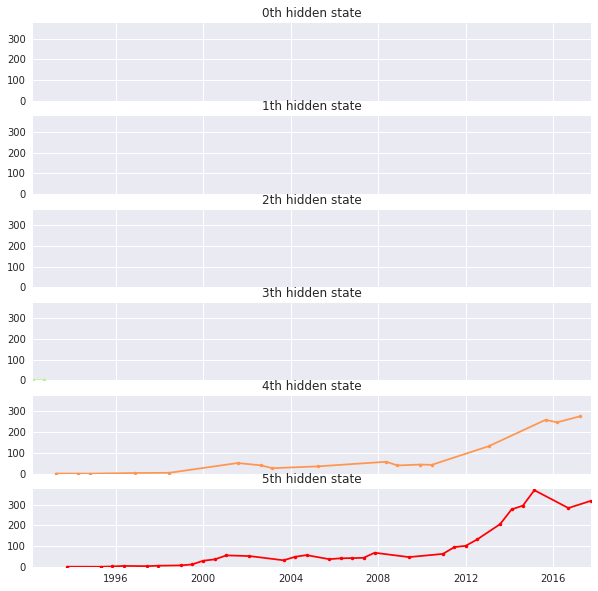

In [16]:
# print("Transition matrix")
# print(model.transmat_)
# print()

dates = df_with_emissions["Date"]
close_v = df_with_emissions["Close"]


fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True)
colours = cm.rainbow(numpy.linspace(0, 1, model.n_components))
for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(dates[mask], close_v[mask], ".-", c=colour)
    ax.set_title("{0}th hidden state".format(i))

    # Format the ticks.
#     ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())

    ax.grid(True)

# set axis
plt.xlim(dates[0], dates[len(dates)-1])

# set y-axis
plt.ylim(numpy.amin(close_v), numpy.amax(close_v) + 5)

# plt.xlim(1, 10)
fig.set_size_inches(10, 10)
seaborn.set()
plt.show()


## What states are buy/sell states? 

In [17]:
# States with an overall a large positive diff should be considered buy states
# and states with a negative diff should be sell states

buy_sell = dict.fromkeys(range(NUM_COMPONENTS), 0);

# Iterate through the list of states
for i in range(len(hidden_states)):
    # add the difference 
    diff = df_with_emissions.loc[i,:]['Close Value Difference']
    state = hidden_states[i]
    buy_sell[state] += diff    
    

print(buy_sell)


{0: 0, 1: 0, 2: 0, 3: -1.8800000000000001, 4: -216.44000000000003, 5: 533.91}
